<a href="https://colab.research.google.com/github/sachchit-k/NlpProj/blob/main/FINAL_IntershipStudioProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import string
import re
import numpy 
from numpy import array,argmax,random,take
import pandas as pd
import keras
from keras.models import Sequential


In [3]:
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt


In [4]:
% matplotlib inline
pd.set_option('display.max_colwidth',200)

####function for reading the file of eng-deu sentence pairs

In [5]:
def read_text(filename):
  file=open(filename,mode='rt',encoding='utf-8')
  text=file.read()
  file.close()
  return text

####spliting text into sentences

In [6]:
def to_lines(text):
  sents=text.strip().split('\n')
  sents=[i.split('\t')for i in sents]
  return sents


In [7]:
data=read_text('/content/drive/MyDrive/Proj/1.PROJ/InternshipStudio/deu-eng/deu.txt')
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [8]:
deu_eng.shape

(248311, 3)

In [9]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

####considering first 50000 sentence pairs only

In [10]:
deu_eng=deu_eng[:50,:]

In [11]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run!', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ['Run.', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
       ['Wow!', 'Potzdonner!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)'],
       ['Wow!', 'Donnerwetter!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
       ['Duck!', 'Kopf runter!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #9968521 (wolfgangth)'],
       

####Text to sequence conversion:

In [12]:
#empty lists
eng_l=[]
deu_l=[]

#populate the lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))


In [13]:
eng_l,deu_l

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  2,
  2,
  2],
 [1,
  1,
  2,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  1,
  1,
  2,
  1,
  3,
  4,
  2,
  2,
  1,
  3,
  3,
  3,
  3,
  3,
  2,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  3,
  1,
  1,
  1,
  2,
  2,
  2,
  2])

In [14]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

In [15]:
length_df

,eng,deu
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1
5,1,1
6,1,1
7,1,2
8,1,1
9,1,1


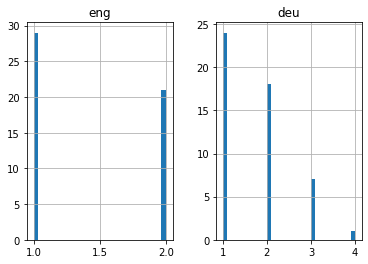

In [16]:
length_df.hist(bins=30)
plt.show()

####Using keras tokenizer sent-->seq of integer
####then we will pad those sequence with zeros to make all the sequcences of same length

In [17]:
#function tp build a tokenizer
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)#fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 
  return tokenizer

In [18]:
#preparing english tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=15

In [19]:
print(eng_tokenizer)

In [20]:
print('English Vocabulary size: %d'% eng_vocab_size)

English Vocabulary size: 36


In [21]:
#preparing Deutch tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=15
print('Deutch Vocabulary Size: %d' %deu_vocab_size)

Deutch Vocabulary Size: 59


####function to prepare sequences.also to perform sequence padding

In [22]:
#encoding and pad sequences
def encode_sequences(tokenizer,length,lines):
  #integer encode sequences
  seq=tokenizer.texts_to_sequences(lines)#texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
  #pad sequences with 0 values
  seq=pad_sequences(seq,maxlen=length,padding='post')
  return seq

####model bulding

In [23]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)

####encoding and decoding part


In [24]:
#preparing training data
#here we are translating from german to eng hence trainX to be deu_
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [25]:
#preparing validation data
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])

In [26]:
from keras.preprocessing.text import Tokenizer
texts = ['These are two crazy sentences', 'that I want to convert back and forth']
tokenizer = Tokenizer(lower=True)
abx=testY
tokenizer.fit_on_texts(texts)
sentences = tokenizer.texts_to_sequences(texts)
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)
my_texts = list(map(sequence_to_text, sentences))


In [27]:
testX
testY

array([[ 1, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

####creating seq to seq model architechtiure
####2 lsmt layer as encoder and decoder

In [28]:
from keras.layers import Embedding, Input
from keras import Model
from tensorflow.keras import optimizers

In [29]:
#built in nmt model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model=Sequential()
  model.add(Embedding(in_vocab,units,input_length=in_timesteps))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units,return_sequences=True))
  model.add(Dense(out_vocab,activation='softmax'))
  return model


####using rmsprop optimizer

In [30]:
# type(model)

In [31]:
model=build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms= optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [32]:
filename='model.1234'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                  epochs=5,batch_size=512,
                  validation_split=0.2,
                  callbacks=[checkpoint],verbose=1)

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.5960
Epoch 00001: val_loss improved from inf to 2.13771, saving model to model.1234


INFO:tensorflow:Assets written to: model.1234/assets


INFO:tensorflow:Assets written to: model.1234/assets


1/1 [==============================] - 26s 26s/step - loss: 3.5960 - val_loss: 2.1377
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 2.1585
Epoch 00002: val_loss improved from 2.13771 to 0.70421, saving model to model.1234


INFO:tensorflow:Assets written to: model.1234/assets


INFO:tensorflow:Assets written to: model.1234/assets


1/1 [==============================] - 11s 11s/step - loss: 2.1585 - val_loss: 0.7042
Epoch 3/5
1/1 [==============================] - ETA: 0s - loss: 0.8648
Epoch 00003: val_loss improved from 0.70421 to 0.42362, saving model to model.1234


INFO:tensorflow:Assets written to: model.1234/assets


INFO:tensorflow:Assets written to: model.1234/assets


1/1 [==============================] - 10s 10s/step - loss: 0.8648 - val_loss: 0.4236
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.5046
Epoch 00004: val_loss improved from 0.42362 to 0.37276, saving model to model.1234


INFO:tensorflow:Assets written to: model.1234/assets


INFO:tensorflow:Assets written to: model.1234/assets


1/1 [==============================] - 11s 11s/step - loss: 0.5046 - val_loss: 0.3728
Epoch 5/5
1/1 [==============================] - ETA: 0s - loss: 0.4200
Epoch 00005: val_loss improved from 0.37276 to 0.35842, saving model to model.1234


INFO:tensorflow:Assets written to: model.1234/assets


INFO:tensorflow:Assets written to: model.1234/assets


1/1 [==============================] - 10s 10s/step - loss: 0.4200 - val_loss: 0.3584


####Comparing traing loss and validation loss

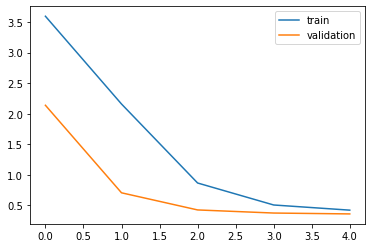

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

####loding the saved model

In [34]:
import numpy as np
import tensorflow
print(tensorflow.__version__)

2.7.0


In [35]:
model=load_model('model.1234')
#https://drive.google.com/drive/folders/1-x61TPTZptvxkFLdbAWvwR5MwUJjORMU?usp=sharing

In [55]:
testX=testX.reshape(testX.shape[0],testX.shape[1])
testY=testY.reshape(testY.shape[0],testY.shape[1])

In [37]:
preds = model.predict(testY).astype("int32")
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
# preds = model.predict_Classes(testX)
# preds= (model.predict(testX.reshape((testX.shape[0],testY.shape[0])))).astype("float64")

In [ ]:
def get_word(n,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==n:
      return word
  return word

In [ ]:
tok = Tokenizer(char_level=True)
# tok.fit_on_texts(text_data)
# reconstructed_text = tok.sequences_to_texts(preds[:,0])

In [57]:
# preds=model.predict(testX).astype("int32") 
classes_x=np.argmax(preds,axis=1)
tokenizer = Tokenizer(lower=True)
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
preds=abx
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in preds]
    return(words)

In [59]:
preds.shape,testX.shape,testY.shape

((10, 15), (10, 15), (10, 15))

In [60]:
#converting prediction into text(English)
 
preds_text=[]
# len(preds)
for i in preds:
  temp=[]

  for j in range(len(i)):
      t=get_word(i[j].all(),eng_tokenizer)
      if j>0:
         if (t==get_word(i[j-1].all(),eng_tokenizer)):
             temp.append(t)
         else:
             temp.append('')
         
preds_text.append(' '.join(temp))


In [61]:
#decoding and pad sequences
def decode_sequences(tokenizer,length,lines):
  #integer encode sequences
  seq=tokenizer.sequences_to_texts(lines)#texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
  #pad sequences with 0 values
  # seq=pad_sequences(seq,maxlen=length,padding='post')
  return seq

In [63]:
# testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])
words=decode_sequences(eng_tokenizer,eng_length,preds)

In [64]:
ppreds = model.predict(testY).astype("int32")


In [65]:
wwords=decode_sequences(eng_tokenizer,eng_length,ppreds[:,0])


In [66]:
# preds_text=array(preds_text)


In [68]:
len(i),eng_length,deu_length,eng_vocab_size,deu_vocab_size

(15, 15, 15, 36, 59)

In [69]:
len(temp),len(test)

(14, 10)

In [70]:
test.shape

(10, 3)

In [71]:
pred_df=pd.DataFrame({'actual':test[:199,0],'predicted':words})

In [72]:
pd.set_option('display.max_colwidth',200)

In [73]:
pred_df.shape,type(test),type(preds)

((10, 2), numpy.ndarray, numpy.ndarray)

In [74]:
pred_df.head()

,actual,predicted
0,I see.,i see
1,Cheers!,cheers
2,Duck!,duck
3,Ask me.,ask me
4,Shoot!,shoot
